In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj
from flicker_model import sim_noise, flicker_cov
from simulation import * 

In [2]:
import pickle
with open('tod_simulation_single.pkl', 'rb') as f:
    tod_sim = pickle.load(f)
# Load the simulation data from a pickle file
with open('multi_tod_simulation_data.pkl', 'rb') as f:
    multi_tod_sim = pickle.load(f)

In [3]:
multi_tod_sim.__dict__.keys()


dict_keys(['nside', 'FWHM', 'threshold', 'freq', 'T_ndiode', 'dtime', 'alpha', 'logf0', 'setting_elevation', 'setting_az_s', 'setting_az_e', 'setting_start_time', 'rising_elevation', 'rising_az_s', 'rising_az_e', 'rising_start_time', 'rec_params', 'gain_params_setting', 'gain_params_rising', 'sigma_2', 'theta_c_setting', 'phi_c_setting', 'bool_map_setting', 'integrated_beam_setting', 't_list', 'theta_c_rising', 'phi_c_rising', 'bool_map_rising', 'integrated_beam_rising', 'full_bool_map', 'pixel_indices', 'integrated_beam', 'Tsky_operator_setting', 'Tsky_operator_rising', 'sky_params', 'ntime', 'ndiode_proj', 'nd_rec_operator', 'nd_rec_params', 'gain_proj', 'gains_setting', 'gains_rising', 'fc', 'logfc', 'f0', 'noise_setting', 'noise_rising', 'Tsys_setting', 'TOD_setting', 'Tsys_rising', 'TOD_rising', 'pixels_c_setting', 'bool_map_c_setting', 'calibration_1_index', 'calibration_5_indices'])

In [4]:
# High-pass filter the calibrated TOD (keep only the high-frequency components, f>0.001)

from scipy import signal


def get_filtfilt_matrix(n_samples, b, a):
    """
    More accurate matrix representation of filtfilt operation.
    """
    
    # Create matrix by applying filtfilt to each standard basis vector
    H = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        e_i = np.zeros(n_samples)
        e_i[i] = 1.0
        H[:, i] = signal.filtfilt(b, a, e_i)
    
    return H


fs = 1.0 / multi_tod_sim.dtime
nyquist = fs / 2.0
normalized_cutoff = 0.001 / nyquist # Normalized cutoff frequency for high-pass filter
b, a = signal.butter(4, normalized_cutoff, btype='high', analog=False)

n_samples_s = len(multi_tod_sim.TOD_setting)
n_samples_r = len(multi_tod_sim.TOD_rising)

H_s_exact = get_filtfilt_matrix(n_samples_s, b, a)
H_r_exact = get_filtfilt_matrix(n_samples_r, b, a)


# DC_gain_s = multi_tod_sim.gain_params_setting[0]
# TOD_rec_s = multi_tod_sim.nd_rec_operator @ multi_tod_sim.nd_rec_params
# calibrated_TOD_s = multi_tod_sim.TOD_setting / DC_gain_s - TOD_rec_s
# HP_calibrated_TOD_s = H_s_exact @ calibrated_TOD_s
# HP_Tsky_operator_s = H_s_exact @ multi_tod_sim.Tsky_operator_setting

# DC_gain_r = multi_tod_sim.gain_params_rising[0]
# TOD_rec_r = multi_tod_sim.nd_rec_operator @ multi_tod_sim.nd_rec_params
# calibrated_TOD_r = multi_tod_sim.TOD_rising / DC_gain_r - TOD_rec_r
# HP_calibrated_TOD_r = H_r_exact @ calibrated_TOD_r
# HP_Tsky_operator_r = H_r_exact @ multi_tod_sim.Tsky_operator_rising

DC_gain_s = multi_tod_sim.gain_params_setting[0]
calibrated_TOD_s = multi_tod_sim.TOD_setting / DC_gain_s 
HP_calibrated_TOD_s = H_s_exact @ calibrated_TOD_s
# cocatenate along columns
aux_ope = np.zeros_like(multi_tod_sim.nd_rec_operator)
Tsys_ope_s = np.concatenate([multi_tod_sim.Tsky_operator_setting, multi_tod_sim.nd_rec_operator, aux_ope], axis=1)
HP_Tsky_operator_s = H_s_exact @ Tsys_ope_s

DC_gain_r = multi_tod_sim.gain_params_rising[0]
calibrated_TOD_r = multi_tod_sim.TOD_rising / DC_gain_r 
HP_calibrated_TOD_r = H_r_exact @ calibrated_TOD_r
# cocatenate along columns
Tsys_ope_r = np.concatenate([multi_tod_sim.Tsky_operator_rising, aux_ope, multi_tod_sim.nd_rec_operator], axis=1)
HP_Tsky_operator_r = H_r_exact @ Tsys_ope_r

In [5]:
# Define Wiener filter for mapmaking of the TOD

def wiener_filter_map(TOD, operator, noise_variance=None, signal_prior_inv_variance=None, guess=None,
                      regularization=1e-12):
    """
    Apply Wiener filtering for mapmaking from time-ordered data.
    
    The Wiener filter solves: (A^T N^-1 A + S^-1)^-1 A^T N^-1 d
    where A is the operator, N is noise covariance, S is signal covariance, d is data
    
    Parameters:
    -----------
    TOD : array-like, shape (n_time,)
        Time-ordered data to be mapped
    operator : array-like, shape (n_time, n_pixels)
        Pointing/beam operator mapping sky pixels to TOD samples
    noise_variance : float or array-like, optional
        Noise variance. If None, estimated from TOD
    signal_prior_inv_variance : float or array-like, optional
        Inverse of Prior variance for sky signal. If None, uses uninformative prior
    regularization : float, default=1e-12
        Regularization parameter to ensure matrix invertibility
        
    Returns:
    --------
    sky_map : array, shape (n_pixels,)
        Reconstructed sky map
    uncertainty : array, shape (n_pixels,)
        Per-pixel uncertainty (diagonal of covariance matrix)
    """
    import numpy as np
    from scipy.sparse import diags
    from scipy.linalg import solve, LinAlgError
    
    # Convert inputs to numpy arrays
    TOD = np.asarray(TOD)
    operator = np.asarray(operator)
    
    n_time, n_pixels = operator.shape
    
    # Estimate noise variance if not provided
    if noise_variance is None:
        # Simple estimate: variance of high-pass filtered residuals
        residual = TOD - operator @ np.linalg.pinv(operator) @ TOD
        noise_variance = np.var(residual)
        print(f"Estimated noise variance: {noise_variance:.6f}")
    
    # Set signal prior variance if not provided (uninformative prior)
    if signal_prior_inv_variance is None:
        signal_prior_inv_variance = 1/ (1e6 * noise_variance)  # Large compared to noise

    # Create noise inverse covariance matrix (assume diagonal)
    if np.isscalar(noise_variance):
        N_inv = np.eye(n_time) / noise_variance
    else:
        N_inv = diags(1.0 / np.asarray(noise_variance))
    
    # Create signal inverse covariance matrix (assume diagonal)
    if np.isscalar(signal_prior_inv_variance):
        S_inv = np.eye(n_pixels) * signal_prior_inv_variance
    else:
        S_inv = diags(1.0 * np.asarray(signal_prior_inv_variance))

    if guess is None:
        guess = np.zeros(n_pixels)

    # Compute Wiener filter components
    AtN = operator.T @ N_inv  # A^T N^-1
    AtNA = AtN @ operator     # A^T N^-1 A
    
    # Add signal prior and regularization
    covariance_inv = AtNA + S_inv + regularization * np.eye(n_pixels)
    
    # Right-hand side: A^T N^-1 d +  S^-1 mu
    rhs = AtN @ TOD + S_inv @ guess 

    try:
        # Solve the linear system: (A^T N^-1 A + S^-1) x = A^T N^-1 d +  S^-1 mu
        sky_map = solve(covariance_inv, rhs, assume_a='pos')
        
        # Compute uncertainties (diagonal of posterior covariance)
        try:
            posterior_cov = np.linalg.inv(covariance_inv)
            uncertainty = np.sqrt(np.diag(posterior_cov))
        except (LinAlgError, np.linalg.LinAlgError):
            print("Warning: Could not compute full covariance matrix. Using diagonal approximation.")
            uncertainty = 1.0 / np.sqrt(np.diag(covariance_inv))
            
    except (LinAlgError, np.linalg.LinAlgError) as e:
        print(f"Linear algebra error: {e}")
        print("Falling back to pseudo-inverse solution...")
        sky_map = np.linalg.pinv(operator) @ TOD
        uncertainty = np.ones(n_pixels) * np.nan
    
    return sky_map, uncertainty


# Alternative simplified version for quick mapmaking
def simple_wiener_map(TOD, operator, noise_var=None):
    """
    Simplified Wiener filter assuming uninformative signal prior.
    Equivalent to: (A^T A + lambda*I)^-1 A^T d
    """
    import numpy as np
    
    if noise_var is None:
        # Estimate from residuals
        residual = TOD - operator @ np.linalg.pinv(operator) @ TOD
        noise_var = np.var(residual)
    
    AtA = operator.T @ operator
    regularization = noise_var * 1e-6  # Small regularization
    
    # Regularized normal equation
    lhs = AtA + regularization * np.eye(AtA.shape[0])
    rhs = operator.T @ TOD
    
    sky_map = np.linalg.solve(lhs, rhs)
    
    return sky_map

In [6]:
prior_std_frac = 0.1
Tsky_prior_inv_cov = 1/ (prior_std_frac * multi_tod_sim.sky_params)**2
# Tsky_prior_cov_inv[multi_tod_sim.calibration_5_indices] = 1e20


aux = 1.0 / (multi_tod_sim.nd_rec_params)**2  # Prior STD ~100%
aux[0] = 10.0
aux[1] = 1.0

# nd_rec_prior = np.zeros_like(multi_tod_sim.nd_rec_params)
# nd_rec_prior[0] = 1.0 

Tsys_prior_inv_cov = np.concatenate([Tsky_prior_inv_cov, aux, aux], axis=0)
Tsys_prior_mean = np.concatenate([multi_tod_sim.sky_params, multi_tod_sim.nd_rec_params, multi_tod_sim.nd_rec_params], axis=0)

In [7]:
# Now your TOD and operator are consistently filtered
HP_calibrated_TOD = np.concatenate([HP_calibrated_TOD_s, HP_calibrated_TOD_r])
# Concatenate the high-pass filtered operators
HP_operator_consistent = np.concatenate([HP_Tsky_operator_s, HP_Tsky_operator_r])

# Apply Wiener filter with consistently filtered operator
estmation, uncertainty = wiener_filter_map(
    HP_calibrated_TOD, HP_operator_consistent, #signal_prior_variance=Tsky_prior_cov, guess=multi_tod_sim.sky_params
    signal_prior_inv_variance=Tsys_prior_inv_cov, guess=Tsys_prior_mean 
)

HP_wiener_map_consistent = estmation[:473]
HP_wiener_uncertainty_consistent = uncertainty[:473]

Estimated noise variance: 0.060618


In [8]:
def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map

def gnomview_patch(map, 
                   pixel_indices, 
                   lon_center, 
                   lat_center,
                   res,
                   sky_min, 
                   sky_max,
                   title=" ",
                   save_path=None, 
                   cmap='jet',
                   cbar=True,
                   xtick=False,
                   ytick=False,
                   unit='K',
                   turn_into_map=True,
                   fts=16,
                   xlabel=None, 
                   ylabel=None):
    NPIX = hp.nside2npix(64)
    if turn_into_map:
        aux_map = np.zeros(NPIX, dtype=float)
        aux_map[pixel_indices] = map
    else:
        aux_map = map
    patch_only_map = view_patch_map(aux_map, pixel_indices)
    hp.gnomview( patch_only_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=220, reso=res, title=title, 
           unit=unit, cmap=cmap, min=sky_min, max=sky_max,
           notext=True,
           coord=['C'], 
           cbar=cbar, 
           badcolor='gray')
    cb = plt.gcf().axes[-1]  # Get the colorbar axis (usually the last one)
    cb.tick_params(labelsize=fts)  # Set the font size to 18 (adjust as needed)
    hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  # Add graticule lines; separation in degrees
    plt.gca().set_facecolor('gray')  # Set background to gray

    # Add axis labels using plt.text
    fig = plt.gcf()
    ax = plt.gca()
    if title and title.strip():  # Only if title is not empty
        ax.set_title(title, fontsize=fts-1, pad=5)

    if cbar:
        if xtick:
            fig.text(0.5, 0.185, str(lon_center)[:7], ha='center', fontsize=fts-1)
        if ytick:
            fig.text(0.045, 0.37, str(lat_center)[:5], va='center', rotation='vertical', fontsize=fts-1)
        if xlabel is not None:
            fig.text(0.5, 0.155, xlabel, ha='center', fontsize=fts-1)
        if ylabel is not None:
            fig.text(0.01, 0.4, ylabel, va='center', rotation='vertical', fontsize=fts-1)
    else:
        if xtick:
            fig.text(0.5, 0.31, str(lon_center)[:7], ha='center', fontsize=fts-1)
        if ytick:
            fig.text(0.045, 0.5, str(lat_center)[:5], va='center', rotation='vertical', fontsize=fts-1)
        if xlabel is not None:
            fig.text(0.5, 0.28, xlabel, ha='center', fontsize=fts-1)
        if ylabel is not None:
            fig.text(0.01, 0.5, ylabel, va='center', rotation='vertical', fontsize=fts-1)

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', 
                pad_inches=0.1)
    
    pass

In [9]:
theta, phi = hp.pix2ang(multi_tod_sim.nside, tod_sim.pixel_indices)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_92269/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


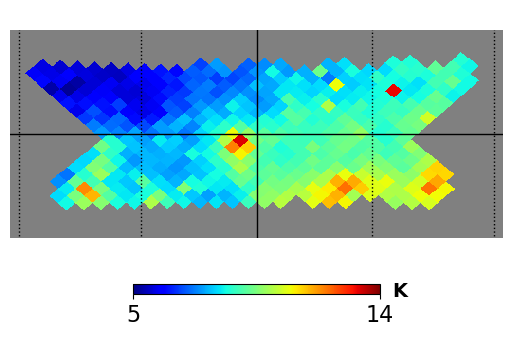

In [10]:
gnomview_patch(HP_wiener_map_consistent, 
               multi_tod_sim.pixel_indices, 
               lon_center, 
               lat_center,
               res,
               5, 
               14,
               cbar=True,
               xtick=False,
               ytick=False,
               xlabel=None,
               ylabel=None,
               save_path="figures/new/hp_wiener_estimation.pdf",
               turn_into_map=True,
               )

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_92269/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


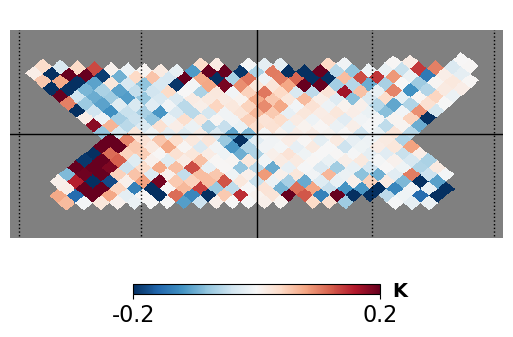

In [11]:
residuals = HP_wiener_map_consistent - multi_tod_sim.sky_params

gnomview_patch(residuals, 
               multi_tod_sim.pixel_indices, 
               lon_center, 
               lat_center,
               res,
               -0.2, 
               0.2,
               cmap='RdBu_r',
               cbar=True,
            #    xtick=True,
            #    ytick=True,
            #    xlabel='Longitude (deg)',
            #    ylabel='Latitude (deg)',
               xlabel=None,
               ylabel=None,
               xtick=False,
               ytick=False,
               save_path="figures/new/hp_wiener_residual.pdf",
               turn_into_map=True,
               )

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_92269/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


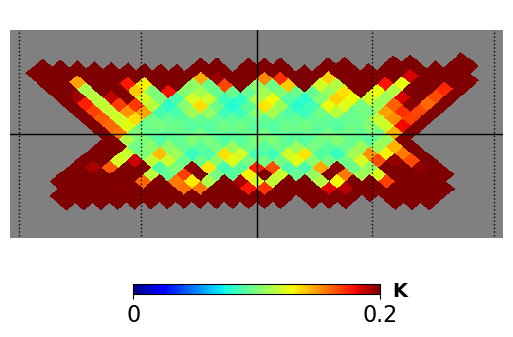

In [12]:
gnomview_patch(HP_wiener_uncertainty_consistent, 
               multi_tod_sim.pixel_indices, 
               lon_center, 
               lat_center,
               res,
               0, 
               0.2,
               cbar=True,
            #    xtick=True,
            #    ytick=True,
            #    xlabel='Longitude (deg)',
            #    ylabel='Latitude (deg)',
                xlabel=None,
                ylabel=None,
                xtick=False,
                ytick=False,
               save_path="figures/new/hp_wiener_uncertainty.pdf",
               turn_into_map=True,
               )

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_92269/3814655908.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


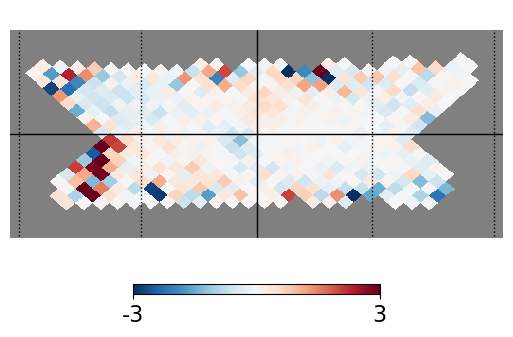

In [13]:
zscore = residuals  / np.std(residuals)
gnomview_patch(zscore, 
               multi_tod_sim.pixel_indices, 
               lon_center, 
               lat_center,
               res,
               -3.0, 
               3.0,
               cmap='RdBu_r',
               cbar=True,
               unit='',
            #    xtick=True,
            #    ytick=True,
            #    xlabel='Longitude (deg)',
            #    ylabel='Latitude (deg)',
                xlabel=None,
                ylabel=None,
                xtick=False,
                ytick=False,
               save_path="figures/new/hp_wiener_zscore.pdf",
               turn_into_map=True,
               )